In [1]:
import convexgating as cg
import scanpy as sc
import convexgating as cg
import anndata as ann
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import os
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
base_path = os.getcwd()
pre = 'rev05_NatComm'

In [3]:
def generate_synthetic_data(n_cells,n_features,n_centers,cluster_std,n_clusters):
    X,y = make_blobs(n_cells, n_features=n_features, centers=n_centers,cluster_std = cluster_std)
    
    var_names = []
    for j in range(1,n_features+1):
        var_names.append('feature_' +str(j))
        
    adata = ann.AnnData(X=X)
    adata.var.index = var_names
    
    model = KMeans(n_clusters = n_clusters)
    model.fit(adata.X)
    labels = model.labels_
    adata.obs['KMeans'] = [str(i) for i in labels]
    return adata

In [4]:
base_data = 'C:\\Users\\vfriedrich\\projects\\gating\\reproducibility\\Figure_5\\oetjen_all.h5ad'
base_save_path = 'C:\\Users\\vfriedrich\\projects\\gating\\revision\\NatComm\\rev06_NatComm'

In [5]:
level = 'cell_type_lvl2'
oetjen_all = sc.read_h5ad(base_data)

results = []
oetjen_all = sc.read_h5ad(base_data)
samples = list(pd.unique(oetjen_all.obs['sample']))
for sample in samples:
    oetjen = oetjen_all[oetjen_all.obs['sample'] == sample]
    sc.pp.subsample(oetjen,n_obs=10000)
    cts = pd.unique(oetjen.obs[level])
    cts = [item for item in cts if "not annotated" not in item]
    for ct in cts:
        oetjen.obs['label'] = (oetjen.obs[level] == ct)
        cell_data = cg.tools.preprocess_adata_gating(oetjen, cluster_string = 'label')
        channels = list(oetjen.var.index)
        
        start_heuristic = time.time()
        best_markers_heuristic = cg.helper.return_best_marker_combo(cell_data, channels)
        end_heuristic = time.time()
        heuristic_comp_time = end_heuristic - start_heuristic
        
        start_tree = time.time()
        best_markers_tree = cg.helper.return_best_marker_combo_single_tree(cell_data, channels)
        end_tree = time.time()
        tree_comp_time = end_tree - start_tree
        
        start_svm = time.time()
        best_markers_svm = cg.helper.return_best_marker_combo_single_svm(cell_data, channels)
        end_svm = time.time()
        svm_comp_time = end_svm - start_svm
        
        
        
        df_heuristic = pd.DataFrame(best_markers_heuristic, columns=['marker', 'heuristic'])
        df_heuristic['heuristic_rank'] = df_heuristic['heuristic'].rank(ascending=False, method='dense').astype(int)
        
        df_tree = pd.DataFrame(best_markers_tree, columns=['marker', 'tree'])
        df_tree['tree_rank'] = df_tree['tree'].rank(ascending=False, method='dense').astype(int)
        
        df_svm = pd.DataFrame(best_markers_svm, columns=['marker', 'svm'])
        df_svm['svm_rank'] = df_svm['svm'].rank(ascending=False, method='dense').astype(int)
        
        df_merged = pd.merge(df_heuristic, df_tree, on='marker', how='inner')
        df_merged = pd.merge(df_merged, df_svm, on='marker', how='inner')
        
        rank_cols = ['heuristic_rank', 'tree_rank', 'svm_rank']
        spearman_corr = df_merged[rank_cols].corr(method='spearman')

        top10_heuristic = set(df_heuristic.sort_values('heuristic', ascending=False).head(10)['marker'])
        top10_tree = set(df_tree.sort_values('tree', ascending=False).head(10)['marker'])
        top10_svm = set(df_svm.sort_values('svm', ascending=False).head(10)['marker'])
        
        # Overlap and union sizes
        intersection_ht = top10_heuristic & top10_tree
        intersection_hs = top10_heuristic & top10_svm
        intersection_ts = top10_tree & top10_svm
        
        union_ht = top10_heuristic | top10_tree
        union_hs = top10_heuristic | top10_svm
        union_ts = top10_tree | top10_svm
        
        # IoU calculations
        iou_heuristic_tree = len(intersection_ht) / len(union_ht) if union_ht else 0
        iou_heuristic_svm = len(intersection_hs) / len(union_hs) if union_hs else 0
        iou_tree_svm = len(intersection_ts) / len(union_ts) if union_ts else 0
        
        results.append({
    'level': level,
    'celltype': ct,
    'sample': sample,
    'heuristic_time': heuristic_comp_time,
    'tree_time': tree_comp_time,
    'svm_time': svm_comp_time,
    'heuristic_tree_corr': spearman_corr.loc['heuristic_rank', 'tree_rank'],
    'heuristic_svm_corr': spearman_corr.loc['heuristic_rank', 'svm_rank'],
    'tree_svm_corr': spearman_corr.loc['tree_rank', 'svm_rank'],
    'iou_heuristic_tree': iou_heuristic_tree,
    'iou_heuristic_svm': iou_heuristic_svm,
    'iou_tree_svm': iou_tree_svm
})
df_results_lvl2 = pd.DataFrame(results)
df_results_lvl2.to_csv(os.path.join(base_save_path,"rev06_marker_selection_benchmark_oetjen_lvl2.csv"), index=False)

In [6]:
level = 'cell_type_lvl3'
oetjen_all = sc.read_h5ad(base_data)

results = []
oetjen_all = sc.read_h5ad(base_data)
samples = list(pd.unique(oetjen_all.obs['sample']))
for sample in samples:
    oetjen = oetjen_all[oetjen_all.obs['sample'] == sample]
    sc.pp.subsample(oetjen,n_obs=10000)
    cts = pd.unique(oetjen.obs[level])
    cts = [item for item in cts if "not annotated" not in item]
    for ct in cts:
        oetjen.obs['label'] = (oetjen.obs[level] == ct)
        cell_data = cg.tools.preprocess_adata_gating(oetjen, cluster_string = 'label')
        channels = list(oetjen.var.index)
        
        start_heuristic = time.time()
        best_markers_heuristic = cg.helper.return_best_marker_combo(cell_data, channels)
        end_heuristic = time.time()
        heuristic_comp_time = end_heuristic - start_heuristic
        
        start_tree = time.time()
        best_markers_tree = cg.helper.return_best_marker_combo_single_tree(cell_data, channels)
        end_tree = time.time()
        tree_comp_time = end_tree - start_tree
        
        start_svm = time.time()
        best_markers_svm = cg.helper.return_best_marker_combo_single_svm(cell_data, channels)
        end_svm = time.time()
        svm_comp_time = end_svm - start_svm
        
        
        
        df_heuristic = pd.DataFrame(best_markers_heuristic, columns=['marker', 'heuristic'])
        df_heuristic['heuristic_rank'] = df_heuristic['heuristic'].rank(ascending=False, method='dense').astype(int)
        
        df_tree = pd.DataFrame(best_markers_tree, columns=['marker', 'tree'])
        df_tree['tree_rank'] = df_tree['tree'].rank(ascending=False, method='dense').astype(int)
        
        df_svm = pd.DataFrame(best_markers_svm, columns=['marker', 'svm'])
        df_svm['svm_rank'] = df_svm['svm'].rank(ascending=False, method='dense').astype(int)
        
        df_merged = pd.merge(df_heuristic, df_tree, on='marker', how='inner')
        df_merged = pd.merge(df_merged, df_svm, on='marker', how='inner')
        
        rank_cols = ['heuristic_rank', 'tree_rank', 'svm_rank']
        spearman_corr = df_merged[rank_cols].corr(method='spearman')

        top10_heuristic = set(df_heuristic.sort_values('heuristic', ascending=False).head(10)['marker'])
        top10_tree = set(df_tree.sort_values('tree', ascending=False).head(10)['marker'])
        top10_svm = set(df_svm.sort_values('svm', ascending=False).head(10)['marker'])
        
        # Overlap and union sizes
        intersection_ht = top10_heuristic & top10_tree
        intersection_hs = top10_heuristic & top10_svm
        intersection_ts = top10_tree & top10_svm
        
        union_ht = top10_heuristic | top10_tree
        union_hs = top10_heuristic | top10_svm
        union_ts = top10_tree | top10_svm
        
        # IoU calculations
        iou_heuristic_tree = len(intersection_ht) / len(union_ht) if union_ht else 0
        iou_heuristic_svm = len(intersection_hs) / len(union_hs) if union_hs else 0
        iou_tree_svm = len(intersection_ts) / len(union_ts) if union_ts else 0
        
        results.append({
    'level': level,
    'celltype': ct,
    'sample': sample,
    'heuristic_time': heuristic_comp_time,
    'tree_time': tree_comp_time,
    'svm_time': svm_comp_time,
    'heuristic_tree_corr': spearman_corr.loc['heuristic_rank', 'tree_rank'],
    'heuristic_svm_corr': spearman_corr.loc['heuristic_rank', 'svm_rank'],
    'tree_svm_corr': spearman_corr.loc['tree_rank', 'svm_rank'],
    'iou_heuristic_tree': iou_heuristic_tree,
    'iou_heuristic_svm': iou_heuristic_svm,
    'iou_tree_svm': iou_tree_svm
})
        

df_results_lvl3 = pd.DataFrame(results)
df_results_lvl3.to_csv(os.path.join(base_save_path,"rev06_marker_selection_benchmark_oetjen_lvl3.csv"), index=False)

In [7]:
level = 'cell_type_lvl4'
oetjen_all = sc.read_h5ad(base_data)

results = []
oetjen_all = sc.read_h5ad(base_data)
samples = list(pd.unique(oetjen_all.obs['sample']))
for sample in samples:
    oetjen = oetjen_all[oetjen_all.obs['sample'] == sample]
    sc.pp.subsample(oetjen,n_obs=10000)
    cts = pd.unique(oetjen.obs[level])
    cts = [item for item in cts if "not annotated" not in item]
    for ct in cts:
        oetjen.obs['label'] = (oetjen.obs[level] == ct)
        cell_data = cg.tools.preprocess_adata_gating(oetjen, cluster_string = 'label')
        channels = list(oetjen.var.index)
        
        start_heuristic = time.time()
        best_markers_heuristic = cg.helper.return_best_marker_combo(cell_data, channels)
        end_heuristic = time.time()
        heuristic_comp_time = end_heuristic - start_heuristic
        
        start_tree = time.time()
        best_markers_tree = cg.helper.return_best_marker_combo_single_tree(cell_data, channels)
        end_tree = time.time()
        tree_comp_time = end_tree - start_tree
        
        start_svm = time.time()
        best_markers_svm = cg.helper.return_best_marker_combo_single_svm(cell_data, channels)
        end_svm = time.time()
        svm_comp_time = end_svm - start_svm
        
        
        
        df_heuristic = pd.DataFrame(best_markers_heuristic, columns=['marker', 'heuristic'])
        df_heuristic['heuristic_rank'] = df_heuristic['heuristic'].rank(ascending=False, method='dense').astype(int)
        
        df_tree = pd.DataFrame(best_markers_tree, columns=['marker', 'tree'])
        df_tree['tree_rank'] = df_tree['tree'].rank(ascending=False, method='dense').astype(int)
        
        df_svm = pd.DataFrame(best_markers_svm, columns=['marker', 'svm'])
        df_svm['svm_rank'] = df_svm['svm'].rank(ascending=False, method='dense').astype(int)
        
        df_merged = pd.merge(df_heuristic, df_tree, on='marker', how='inner')
        df_merged = pd.merge(df_merged, df_svm, on='marker', how='inner')
        
        rank_cols = ['heuristic_rank', 'tree_rank', 'svm_rank']
        spearman_corr = df_merged[rank_cols].corr(method='spearman')

        top10_heuristic = set(df_heuristic.sort_values('heuristic', ascending=False).head(10)['marker'])
        top10_tree = set(df_tree.sort_values('tree', ascending=False).head(10)['marker'])
        top10_svm = set(df_svm.sort_values('svm', ascending=False).head(10)['marker'])
        
        # Overlap and union sizes
        intersection_ht = top10_heuristic & top10_tree
        intersection_hs = top10_heuristic & top10_svm
        intersection_ts = top10_tree & top10_svm
        
        union_ht = top10_heuristic | top10_tree
        union_hs = top10_heuristic | top10_svm
        union_ts = top10_tree | top10_svm
        
        # IoU calculations
        iou_heuristic_tree = len(intersection_ht) / len(union_ht) if union_ht else 0
        iou_heuristic_svm = len(intersection_hs) / len(union_hs) if union_hs else 0
        iou_tree_svm = len(intersection_ts) / len(union_ts) if union_ts else 0
        
        results.append({
    'level': level,
    'celltype': ct,
    'sample': sample,
    'heuristic_time': heuristic_comp_time,
    'tree_time': tree_comp_time,
    'svm_time': svm_comp_time,
    'heuristic_tree_corr': spearman_corr.loc['heuristic_rank', 'tree_rank'],
    'heuristic_svm_corr': spearman_corr.loc['heuristic_rank', 'svm_rank'],
    'tree_svm_corr': spearman_corr.loc['tree_rank', 'svm_rank'],
    'iou_heuristic_tree': iou_heuristic_tree,
    'iou_heuristic_svm': iou_heuristic_svm,
    'iou_tree_svm': iou_tree_svm
})
        

df_results_lvl4 = pd.DataFrame(results)
df_results_lvl4.to_csv(os.path.join(base_save_path,"rev06_marker_selection_benchmark_oetjen_lvl4.csv"), index=False)

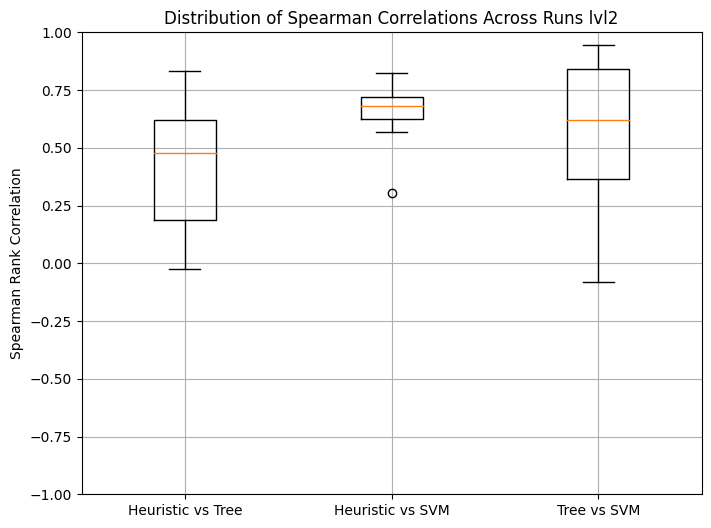

In [8]:
corr_data = df_results_lvl2[['heuristic_tree_corr', 'heuristic_svm_corr', 'tree_svm_corr']]
corr_data.columns = ['Heuristic vs Tree', 'Heuristic vs SVM', 'Tree vs SVM']

# Plot boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(corr_data.values, labels=corr_data.columns)
plt.ylabel("Spearman Rank Correlation")
plt.title("Distribution of Spearman Correlations Across Runs lvl2")
plt.grid(True)
plt.ylim([-1,1])
plt.savefig(os.path.join(base_save_path,"rev06_corrlelation_oetjen_lvl2.pdf"),bbox_inches = 'tight')
plt.show()

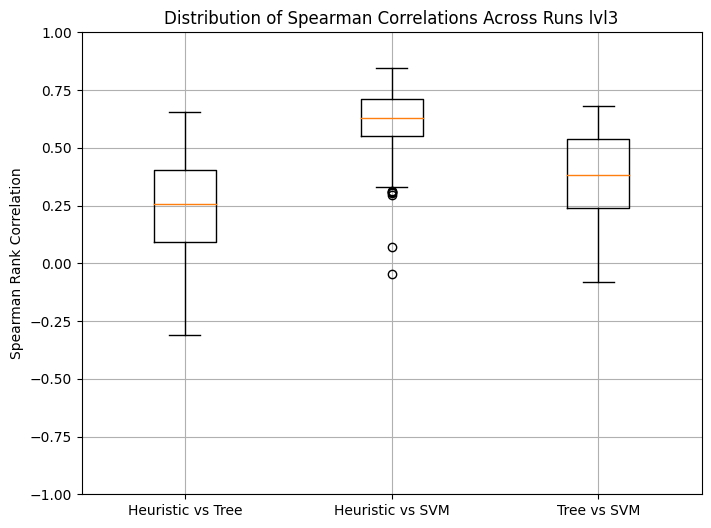

In [9]:
corr_data = df_results_lvl3[['heuristic_tree_corr', 'heuristic_svm_corr', 'tree_svm_corr']]
corr_data.columns = ['Heuristic vs Tree', 'Heuristic vs SVM', 'Tree vs SVM']

# Plot boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(corr_data.values, labels=corr_data.columns)
plt.ylabel("Spearman Rank Correlation")
plt.title("Distribution of Spearman Correlations Across Runs lvl3")
plt.grid(True)
plt.ylim([-1,1])
plt.savefig(os.path.join(base_save_path,"rev06_corrlelation_oetjen_lvl3.pdf"),bbox_inches = 'tight')
plt.show()

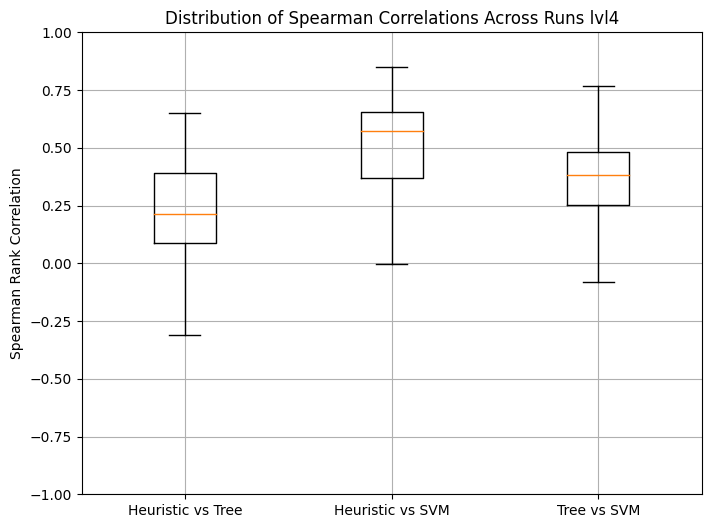

In [10]:
corr_data = df_results_lvl4[['heuristic_tree_corr', 'heuristic_svm_corr', 'tree_svm_corr']]
corr_data.columns = ['Heuristic vs Tree', 'Heuristic vs SVM', 'Tree vs SVM']

# Plot boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(corr_data.values, labels=corr_data.columns)
plt.ylabel("Spearman Rank Correlation")
plt.title("Distribution of Spearman Correlations Across Runs lvl4")
plt.grid(True)
plt.ylim([-1,1])
plt.savefig(os.path.join(base_save_path,"rev06_corrlelation_oetjen_lvl4.pdf"),bbox_inches = 'tight')
plt.show()